# Предсказание цен машин с Юлы




In [1]:
from tensorflow import keras
from tensorflow.keras.models import Sequential # НС прямого распространения
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization # Основные слои
from tensorflow.keras import utils # Утилиты для to_categorical
from tensorflow.keras.preprocessing import image # Для отрисовки изображения
from tensorflow.keras.optimizers import Adam, Adadelta # Алгоритмы оптимизации, для настройки скорости обучения
import numpy as np # Библиотека работы с массивами
import matplotlib.pyplot as plt # Отрисовка изображений
from PIL import Image # Отрисовка изображений
import pandas as pd # Библиотека pandas
from google.colab import files # Импорт файлов
from sklearn.preprocessing import LabelEncoder, StandardScaler # Функции для нормализации данных
from sklearn import preprocessing # Пакет предварительной обработки данных
from sklearn.model_selection import train_test_split
# Отрисовывать изображения в ноутбуке, а не в консоль или файл
%matplotlib inline

In [2]:
# Считываем csv с помощью pandas
cars = pd.read_csv('cars_new.csv', sep=',')
cars[:5] # Выводим первые 5 машин

,mark,model,price,year,mileage,body,kpp,fuel,volume,power
0,kia,cerato,996000,2018,28000,седан,автомат,бензин,2.0,150.0
1,daewoo,nexia 1 поколение [2-й рестайлинг],140200,2012,60500,седан,механика,бензин,1.5,80.0
2,suzuki,jimny 3 поколение [рестайлинг],750000,2011,29000,внедорожник,автомат,бензин,1.3,85.0
3,bmw,x1 18 e84 [рестайлинг],970000,2014,49500,кроссовер,автомат,бензин,2.0,150.0
4,chevrolet,lacetti 1 поколение,205000,2007,151445,седан,механика,бензин,1.4,95.0


In [3]:
print(cars.values.shape)

(70119, 10)


In [4]:
# Создаём словарь поле - его индекс
def create_dict(s):
  ret = {}                          # Создаём пустой словарь
  for _id, name in enumerate(s):    # Проходим по всем парам - id и название
    ret.update({name: _id})         # Добавляем в словарь
  return ret

# Функция преобразования в one hot encoding
def to_ohe(value, d):
  arr = [0] * len(d)
  arr[d[value]] = 1
  return arr

In [5]:
# Создаём словари по всем текстовым колонкам
marks_dict = create_dict(set(cars['mark']))
models_dict = create_dict(set(cars['model']))
bodies_dict = create_dict(set(cars['body']))
kpps_dict = create_dict(set(cars['kpp']))
fuels_dict = create_dict(set(cars['fuel']))

# Запоминаем цены
prices = np.array(cars['price'], dtype=np.float)

# Запоминаем числовые параметры
# и нормируем
years = preprocessing.scale(cars['year'])
mileages = preprocessing.scale(cars['mileage'])
volumes = preprocessing.scale(cars['volume'])
powers = preprocessing.scale(cars['power'])

<ipython-input-5-006031011196>:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  prices = np.array(cars['price'], dtype=np.float)


In [6]:
print(fuels_dict)

{'дизель': 0, 'электро': 1, 'гибрид': 2, 'бензин': 3, 'газ': 4}


In [7]:
volumes.mean()

1.2879530757014324e-16

In [8]:
volumes.std()

1.0

In [9]:
print(powers)

[ 0.22905575 -0.95630346 -0.87163494 ...  0.22905575 -0.75309902
  2.34576862]


In [10]:
# Создаём пустую обучающую выборку
x_train = []
y_train = []

# Проходам по всем машинам
for _id, car in enumerate(np.array(cars)):
  # В y_train добавляем цену
  y_train.append(prices[_id])

  # В x_train объединяем все параметры
  # Категорийные параметры добавляем в виде ohe
  # Числовые параметры добавляем напрямую
  x_tr = to_ohe(car[0], marks_dict) + \
        to_ohe(car[1], models_dict) + \
        to_ohe(car[5], bodies_dict) + \
        to_ohe(car[6], kpps_dict) + \
        to_ohe(car[7], fuels_dict) + \
        [years[_id]] + \
        [mileages[_id]] + \
        [volumes[_id]] + \
        [powers[_id]]

  # Добавляем текущую строку в общий x_train
  x_train.append(x_tr)

# Превращаем лист в numpy.array
x_train = np.array(x_train, dtype=np.float)
y_train = np.array(y_train, dtype=np.float)

<ipython-input-10-56e6415ba6d7>:27: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x_train = np.array(x_train, dtype=np.float)
<ipython-input-10-56e6415ba6d7>:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_train = np.array(y_train, dtype=np.float)


In [11]:
# Выводим размеры выборок
print(x_train.shape)
print(y_train.shape)

(70119, 3208)
(70119,)


In [12]:
# Выводим один x_train
print(x_train[0,:20])
print(x_train[0,-20:])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[ 0.          0.          1.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          1.          0.          1.5200145  -1.40018212
  0.12288486  0.22905575]


In [13]:
# Выводим y_train
print(y_train[:10])

[ 996000.  140200.  750000.  970000.  205000.  985000.  589000.  500000.
 1320000.  270000.]


In [14]:
y_train.shape

(70119,)

In [15]:
y_train.reshape(-1,1).shape

(70119, 1)

In [16]:
# Нормализуем y_train
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1,1)).flatten()

# y_train.reshape(-1,1) добавляет одну размерность
# Это нужно потому, что y_scaler.fit_transform
# Требует двумерны вектор, массив примеров, которые надо нормализовать
# Он не умеет работать с одним примеров
# Поэтому мы делаем массив из одного примера
# На выходе он так же выдаёт массив примеров
# Но нам нужен только первый пример
# Поэтому мы делаем flatten() - уменьшение размерности

In [17]:
y_train_scaled.shape

(70119,)

In [18]:
# Выводим базовый и нормированный y_train
print(y_train[:10])
print(y_train_scaled[:10])

[ 996000.  140200.  750000.  970000.  205000.  985000.  589000.  500000.
 1320000.  270000.]
[ 0.75082432 -0.62135434  0.3563911   0.70913625 -0.51745486  0.73318706
  0.09824578 -0.04445567  1.27032173 -0.4132347 ]


In [19]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, train_size=0.7, random_state=42, shuffle=True)

In [20]:
model_ula = Sequential([
Dense(128, activation='relu', input_shape=(x_train.shape[1],)),
Dropout(0.3),
Dense(64, activation='relu'),
Dropout(0.2),
Dense(1, activation='linear')
])



In [21]:
model_ula.compile(optimizer='adam', loss='mae', metrics=[keras.metrics.R2Score()])
history = model_ula.fit(x_train, y_train, validation_split=0.2, batch_size=70, epochs=100)

Epoch 1/100
561/561 [==============================] - 8s 12ms/step - loss: 519983.2188 - r2_score: -0.7207 - val_loss: 489633.1562 - val_r2_score: -0.5849
Epoch 2/100
561/561 [==============================] - 6s 12ms/step - loss: 414890.7188 - r2_score: -0.4190 - val_loss: 319819.3125 - val_r2_score: -0.1076
Epoch 3/100
561/561 [==============================] - 6s 10ms/step - loss: 253885.2188 - r2_score: 0.1236 - val_loss: 207305.8594 - val_r2_score: 0.2781
Epoch 4/100
561/561 [==============================] - 8s 13ms/step - loss: 192287.7188 - r2_score: 0.3689 - val_loss: 176524.5781 - val_r2_score: 0.3977
Epoch 5/100
561/561 [==============================] - 6s 11ms/step - loss: 175016.6562 - r2_score: 0.4452 - val_loss: 165712.4531 - val_r2_score: 0.4420
Epoch 6/100
561/561 [==============================] - 8s 15ms/step - loss: 166813.7031 - r2_score: 0.4784 - val_loss: 158354.7031 - val_r2_score: 0.4613
Epoch 7/100
561/561 [==============================] - 6s 10ms/step - lo

In [22]:
y_pred = model_ula.predict(x_test)

658/658 [==============================] - 2s 3ms/step


In [23]:
history.history['r2_score']

[-0.7207192182540894,
 -0.4189838171005249,
 0.12356096506118774,
 0.36894339323043823,
 0.4451507329940796,
 0.4784034490585327,
 0.49820542335510254,
 0.5133236050605774,
 0.5310860872268677,
 0.5517023801803589,
 0.5652976632118225,
 0.5820081830024719,
 0.5959266424179077,
 0.6096962094306946,
 0.6215779185295105,
 0.6324017643928528,
 0.6406775712966919,
 0.646561861038208,
 0.6564950942993164,
 0.6646454334259033,
 0.6720492243766785,
 0.6782033443450928,
 0.6878231763839722,
 0.6885718703269958,
 0.6988885998725891,
 0.7023881077766418,
 0.708564043045044,
 0.7112687230110168,
 0.7192388772964478,
 0.7235862016677856,
 0.7284259796142578,
 0.7305971384048462,
 0.7332038879394531,
 0.7403439283370972,
 0.7442080974578857,
 0.7505704760551453,
 0.7507455348968506,
 0.7569948434829712,
 0.7597915530204773,
 0.7622254490852356,
 0.7669464349746704,
 0.7705840468406677,
 0.7746113538742065,
 0.7777806520462036,
 0.7764163613319397,
 0.7774524688720703,
 0.7815853357315063,
 0.7778401

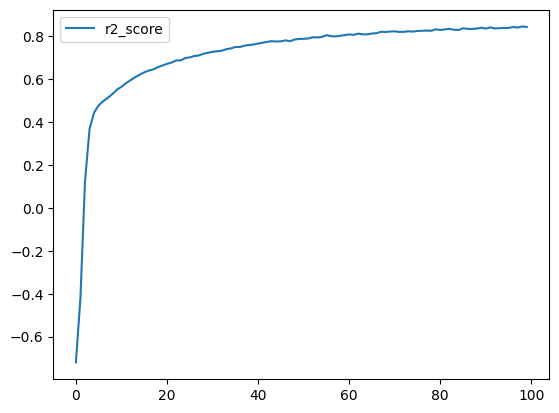

In [24]:
plt.plot(history.history['r2_score'], label='val_r2_score')
plt.legend(['r2_score'])
plt.show()

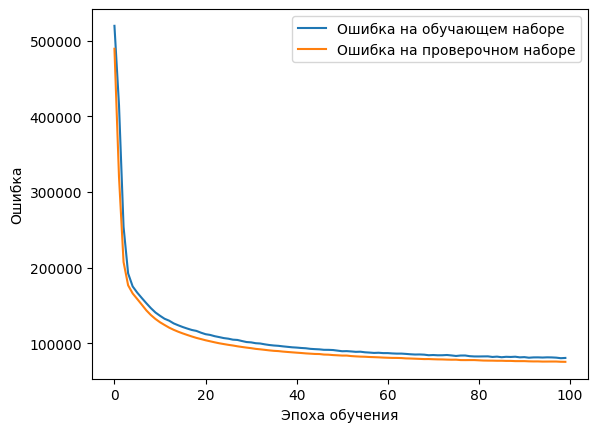

In [25]:
plt.plot(history.history['loss'],
         label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'],
         label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()